# Aula 6 - Classificação e Comparação de Modelos

## Classificação com Aprendizado Supervisionado de Máquina

<p align="justify">  Como já abordamos nas últimas aulas, a tarefa de classificação em machine learning é um dos problemas mais comuns e fundamentais na área da aprendizdo supervisionado. Ela se refere ao processo de utilizar um modelo para que ele atribua uma categoria ou rótulo a um conjunto de dados com base em suas características observáveis. O objetivo principal da classificação é providenciar um banco de dados com observações rotuladas (anotadas) e treiná-lo de forma que ele consiga classificar as observações, com certa precisão, com base nesses dados. Na aula passada, vimos os principais problemas que podem surgir na criação do banco de dados e anotação das observações.



<p align="justify"> O modelo então aprende a reconhecer padrões e relações entre as características dos dados e as classes correspondentes. Uma vez treinado, o modelo pode ser usado para fazer previsões em novos dados não rotulados, classificando-os em uma das classes pré-definidas. A classificação é amplamente aplicada em uma variedade de domínios, como diagnóstico médico, detecção de fraudes financeiras, reconhecimento de padrões em imagens, filtragem de spam de e-mails, análise de sentimentos em texto, entre outros. Ela desempenha um papel crucial na automação de tarefas que exigem a categorização rápida e precisa de grandes volumes de dados, tornando-a uma das áreas mais importantes da machine learning e da inteligência artificial.


<p align="justify"> Na aula de hoje, iremos aprender como aplicar um só modelo de aprendizado de máquina, a regressão logística, em tarefas de classificação simples.  O foco principal é em aprender como utilizár este modelo e como avaliar sua performance, entendendo que não existe um modelo perfeito que supere todos os outros, sendo sempre necessário avaliá-los e compará-los.


### Classificação Binária

<p align="justify"> A tarefa de classificação binária, de forma simples, envolve separar coisas em apenas duas categorias. Imagine que você tem um grupo de animais e deseja classificá-los em "gatos" ou "não gatos". Neste caso, você está realizando uma classificação binária, onde há apenas duas opções possíveis.

<p align="justify"> Em machine learning, o mesmo conceito se aplica, mas você usa um modelo para fazer essa separação automaticamente com base em características dos dados. Por exemplo, um modelo de classificação binária pode ser treinado para distinguir entre e-mails "spam" e "não spam" ou para identificar se uma imagem contém um objeto específico, como um "carro" ou "não carro". Sempre com essa ideia de "Verdadeiro ou falso", "Positivo ou negativo", etc.


#### O Banco de dados *Default*

Vamos utilizar um banco de dados conhecido, o *Default*. Nele, existem características de pessoas que são ou não inadimplentes.

In [1]:
import pandas as pd

# URL do arquivo Excel raw no GitHub
url = "https://github.com/JWarmenhoven/ISLR-python/raw/master/Notebooks/Data/Default.xlsx"

# Carrega o arquivo Excel em um DataFrame
df = pd.read_excel(url)

df.head()

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625074
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138947
3,4,No,No,529.250605,35704.493935
4,5,No,No,785.655883,38463.495879


Temos os seguintes dados: Se a pessoa é estudante ou não (*student*), seu saldo no cartão de crédito (*balance*) e sua renda (*income*). A coluna de interesse é a "default", isto é, se a pessoa é ou não devedora/inadimplente. Primeiro, vamos explorar um pouco o banco de dados

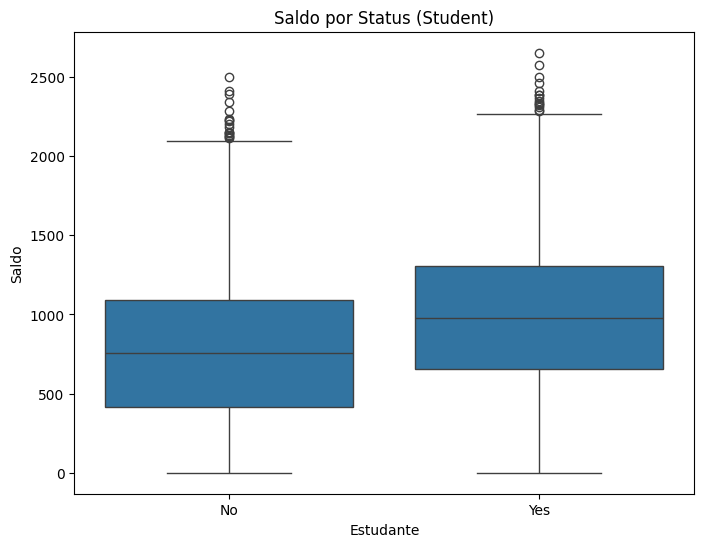

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crie um boxplot do saldo agrupado por estudante usando o Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='student', y='balance')
plt.title('Saldo por Status (Student)')
plt.xlabel('Estudante')
plt.ylabel('Saldo')
plt.show()

A mediana de saldo no cartão de crédito dos estudantes é um pouco maior do que o do resto, e no geral também apresentam maior variação. Vamos ver também a renda desses grupos:

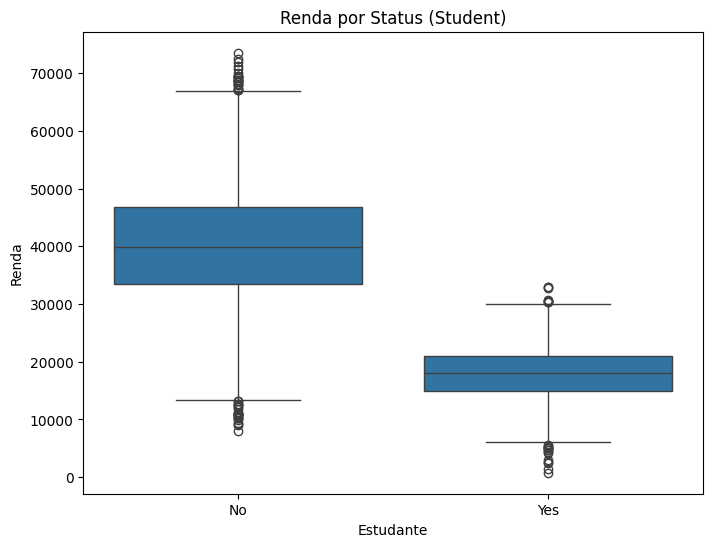

In [3]:
# Crie um boxplot da renda agrupado por estudante usando o Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='student', y='income')
plt.title('Renda por Status (Student)')
plt.xlabel('Estudante')
plt.ylabel('Renda')
plt.show()

Na renda, a diferença entre os grupos é ainda maior. Percebe-se que incluir essa variável no modelo é importante. Vamos olhar também a correlação entre as colunas de renda e balance:




In [4]:
correlation = df['income'].corr(df['balance'])

print(f"Correlação entre 'income' e 'balance': {correlation}")

Correlação entre 'income' e 'balance': -0.15224340058606683


Parece haver uma correlação negativa entre essas duas colunas: aqueles que possuem maior income, terão menor balance, e vice versa. Por fim, uma coisa que sempre é importante verificar antes de partir para a utilização de modelos de aprendizado de máquina é entender a distribuição da sua variável de interesse (neste caso, quem é ou não inadimplente).

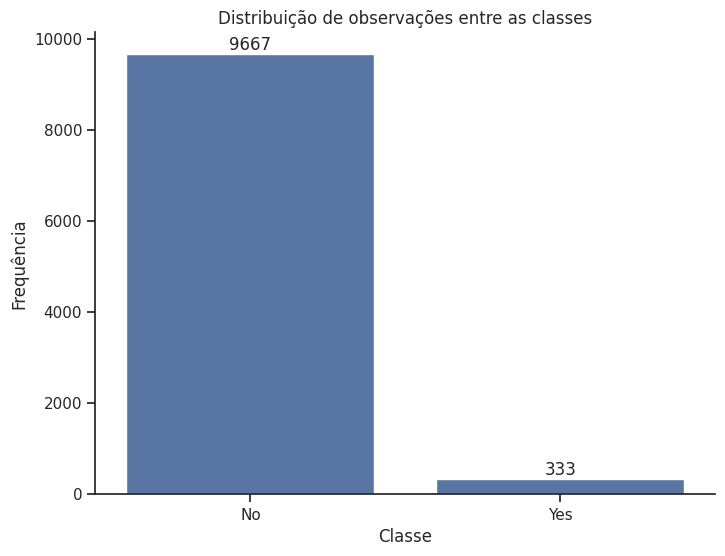

In [5]:
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# Crie o gráfico de barras usando Seaborn
plt.figure(figsize=(8, 6))  # Ajuste o tamanho da figura se necessário

# Countplot (Seaborn)
ax = sns.countplot(x='default', data=df)
ax.bar_label(ax.containers[0])

plt.ylabel("Frequência")
plt.xlabel("Classe")
plt.title("Distribuição de observações entre as classes")

# Mostre o gráfico
plt.show()

Aqui vemos que há um grande desbalanceamento entre as classes. De acordo com o que foi discutido na aula, podemos esperar, com base no pequeno número de observações que são de fato inadimplentes, que o modelo não performará tão bem na classificação de observações desta classe, dado que é minoritária.

#### Regressão Logística

O modelo de regressão logística é uma técnica de aprendizado de máquina que é usada principalmente para tarefas de classificação. Vamos explicá-lo de maneira simples:

A regressão logística, no banco de dados atual, vai procurar prever se determinado indivíduo é ou não um possível devedor com base nas três características presentes. De forma elencada, temos:

* Variável Dependente (Ou *target*) : A coisa que você deseja prever é chamada de variável dependente ou variável-alvo (target). Neste caso, é a inadimplência.

* Variáveis Independentes (*features*): As características das pessoas que você usa para fazer a previsão são chamadas de variáveis independentes ou características (*features*), no contexto de machine learning.

* Função Logística: A regressão logística usa uma função logística, que é uma curva com forma de "S", para transformar a combinação das características em uma probabilidade. Essa probabilidade representa a chance de um evento ocorrer (inadimplência).

* Treinamento: O modelo é treinado usando um conjunto de dados em que você já conhece as respostas (São ou não inadimplentes). O modelo ajusta seus parâmetros para se ajustar aos dados de treinamento e aprender a fazer previsões.

* Limiar de Decisão: Você define um limiar (um valor) acima do qual o modelo prevê que o evento ocorrerá (por exemplo, comprar o produto). Se a probabilidade calculada estiver acima desse limiar, o modelo prevê "sim"; caso contrário, prevê "não".

Em resumo, a regressão logística é usada para prever a probabilidade de um evento binário (duas opções, como "sim" ou "não") com base em características. É uma ferramenta valiosa para tarefas de classificação, como previsão de compras, detecção de spam de e-mail e muito mais. É chamada de "logística" porque usa a função logística para fazer essa previsão.

Vamos partir para o treinamento. Primeiro, precisamos importar alguns pacotes:

In [6]:
import statsmodels.api as sm # Biblioteca de modelos estatísticos
from sklearn.linear_model import LogisticRegression # Modelo de regressão logística do sklearn
from sklearn.model_selection import train_test_split # Função para dividir o banco entre treino e teste
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # Algumas métricas e relatórios

Você pode encontrar uma lista de todos os modelos presentes no sklearn no seguinte [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Vamos por partes:

##### 1. *One-hot encoding*.

<p align="justify"> O "one-hot encoding" é uma técnica importante no pré-processamento de dados, frequentemente usada em tarefas de aprendizado de máquina, especialmente quando lidamos com variáveis categóricas. A necessidade do "one-hot encoding" surge devido a diferenças na forma como os algoritmos de machine learning lidam com variáveis categóricas e numéricas. Vamos explicar essa necessidade em detalhes:

* <p align="justify"> Natureza das Variáveis Categóricas: Variáveis categóricas representam categorias ou grupos discretos de dados, como cores, tipos de veículos, estados civis, etc. Os algoritmos de machine learning, em sua maioria, operam com números e equações, e não têm a capacidade de interpretar diretamente variáveis categóricas. Portanto, é necessário transformar essas categorias em uma forma que os modelos possam compreender.

* <p align="justify"> Representação Numérica: Os modelos de machine learning funcionam melhor com variáveis numéricas. Quando se trata de variáveis categóricas, elas precisam ser codificadas de alguma forma para serem representadas numericamente. O "one-hot encoding" é uma das técnicas mais comuns para fazer essa codificação.

* <p align="justify"> Evitar Suposições Errôneas: Se você simplesmente atribuir números inteiros a categorias (por exemplo, 0 para "vermelho", 1 para "verde" e 2 para "azul"), os algoritmos podem erroneamente assumir que existe uma relação ordinal entre as categorias (ou seja, que "azul" é maior ou melhor do que "verde"). Isso pode levar a resultados incorretos.

O "one-hot encoding" resolve esses problemas da seguinte maneira:

* <p align="justify"> Para cada categoria única em uma variável categórica, é criada uma nova coluna binária (0 ou 1) no conjunto de dados.

* <p align="justify"> Essas colunas binárias representam a presença (1) ou ausência (0) da categoria em cada observação de dados.

* <p align="justify"> Cada categoria é tratada de forma independente, eliminando qualquer suposição de ordem ou relação entre elas.

<p align="justify"> Por exemplo, se tivermos uma variável categórica "cores" com três categorias: "vermelho", "verde" e "azul", o "one-hot encoding" criaria três novas colunas, uma para cada cor, e marcaria as cores presentes em cada observação com 1 e as ausentes com 0.

<p align="justify"> Em resumo, a necessidade do "one-hot encoding" é garantir que as variáveis categóricas sejam representadas de forma adequada e sem ambiguidades, permitindo que os modelos de machine learning compreendam e usem essas informações de maneira eficaz durante o treinamento e a previsão.

In [7]:
# Converte as variáveis categóricas em numéricas usando codificação one-hot
df_encoded = pd.get_dummies(df, columns=['default', 'student'],
                            drop_first=True,
                            dtype=int) # Precisamos dos valores em 0 e 1


df_encoded

,Unnamed: 0,balance,income,default_Yes,student_Yes
0,1,729.526495,44361.625074,0,0
1,2,817.180407,12106.134700,0,1
2,3,1073.549164,31767.138947,0,0
3,4,529.250605,35704.493935,0,0
4,5,785.655883,38463.495879,0,0
...,...,...,...,...,...
9995,9996,711.555020,52992.378914,0,0
9996,9997,757.962918,19660.721768,0,0
9997,9998,845.411989,58636.156984,0,0
9998,9999,1569.009053,36669.112365,0,0


##### 2. Separar Target e Features

Geralmente, não se utiliza as informações na forma direta do dataframe do pandas. Precisamos pegar as colunas do dataframe e separá-las entre o nosso y (ou target, ou variável de interesse) e um vetor com todas nossas variáveis que serão utilizadas na predição (features, ou variáveis independentes).

In [8]:
# Divide os dados em features (X) e target (y)
X = df_encoded[['balance', 'income', 'student_Yes']]
y = df_encoded['default_Yes']

Vou explicar o código linha por linha:

* X = df_encoded[['balance', 'income', 'student_Yes']]:

Nesta linha, está sendo criada uma variável X, que representa as features (ou características) que serão usadas para treinar o nosso modelo de machine learning.

* y = df_encoded['default_Yes']:

Nesta linha, está sendo criada uma variável y, que representa o target (ou rótulo) que o modelo de machine learning tentará prever. df_encoded é o DataFrame que contém os dados originais.

Em resumo, este código separa as features (X), que são 'balance', 'income' e 'student_Yes', e o target (y), que é 'default_Yes', do DataFrame df_encoded. Essas features serão usadas para treinar um modelo de machine learning que tentará prever se um cliente será inadimplente com base nas informações fornecidas nas features.

##### Regressão Logística (STATSMODELS)

Antes de continuarmos para o modelo de regressão logística do Sci-Kit Learn (sklearn), vamos ver os resultados desse modelo no statsmodels, que é mais voltado para a inferência estatística. Vamos rodar uma regressão logística com 'default_YES' como variável dependente e 'balance', 'income' e 'student_Yes' como variáveis independentes (ou explicativas).

In [9]:
import statsmodels.formula.api as smf

# Definindo o modelo da forma default_Yes = balance + income + student_Yes
model = smf.logit('default_Yes ~ balance + income + student_Yes', data=df_encoded).fit()

# Imprimindo o resultado
print(model.summary())



Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:            default_Yes   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9996
Method:                           MLE   Df Model:                            3
Date:                Mon, 23 Sep 2024   Pseudo R-squ.:                  0.4619
Time:                        19:38:15   Log-Likelihood:                -785.77
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                3.257e-292
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -10.8690      0.492    -22.079      0.000     -11.834      -9.904
balance         0.0057   

Olhando para os p-valores dos coeficientes, vemos que renda ('income') não é estatisticamente significante para explicar quem pode ser inadimplente. No entanto, vemos que o saldo no cartão de crédito ('balance') e ser um estudante ('student_Yes') são estatisticamente significantes, com efeitos em direções contrárias. Ser um estudante reduz a chance de inadimplência, e quanto maior o saldo do cartão de crédito, maior a chance de inadimplência. Agora, continuemos com o treinamento do modelo, dividindo o banco entre os dados de treinamento e os dados de teste (ou de avaliação do modelo).

##### 3. Divisão entre Treino e Teste

A divisão de dados entre dados de treino e dados de teste é uma prática fundamental em machine learning para avaliar o desempenho de um modelo de forma objetiva e verificar sua capacidade de generalização. Essa divisão ajuda a garantir que o modelo não esteja apenas memorizando os dados de treino, mas também seja capaz de fazer previsões precisas em novos dados não vistos. Aqui está uma explicação detalhada do processo:

* Conjunto de Dados Inicial: Primeiramente, você começa com um conjunto de dados que contém exemplos de treinamento, que são usados para treinar o modelo, e exemplos de teste, que são usados para avaliar o desempenho do modelo. O conjunto de dados pode ser dividido em três partes: treino, validação e teste, mas aqui vamos nos concentrar na divisão entre treino e teste.

* Divisão Aleatória: Os dados são divididos aleatoriamente em duas partes distintas: o conjunto de treinamento e o conjunto de teste. A divisão aleatória ajuda a garantir que os dados de treinamento e teste sejam representativos do conjunto de dados completo.

* Dados de Treinamento: O conjunto de treinamento é usado para alimentar o modelo durante o processo de treinamento. O modelo aprende com esses dados, ajustando seus parâmetros ou pesos para fazer previsões com base nas características dos exemplos de treinamento.

* Dados de Teste: O conjunto de teste é reservado exclusivamente para avaliar o desempenho do modelo após o treinamento. O modelo não vê esses dados durante o treinamento; portanto, são dados não vistos. Isso é crucial para medir como o modelo generaliza para novos dados.

* Avaliação do Modelo: Após treinar o modelo, ele é testado usando os dados de teste. As previsões do modelo são comparadas com os valores reais (rótulos) dos exemplos de teste. As métricas de avaliação, como precisão, recall, F1-score, matriz de confusão, entre outras, são calculadas com base nessa comparação.

* Ajuste e Otimização: Com base no desempenho do modelo nos dados de teste, você pode fazer ajustes e otimizações no modelo, se necessário. Isso pode incluir a seleção de hiperparâmetros, engenharia de características (feature engineering) e escolha de algoritmos diferentes.

* Validação Cruzada: Além dessa divisão em treino e teste, a validação cruzada (cross-validation) é outra técnica comum que pode ser usada para avaliar o desempenho do modelo de forma mais robusta, principalmente quando o conjunto de dados é pequeno. A validação cruzada divide os dados em várias dobras (folds) e executa várias iterações de treinamento e teste, produzindo métricas de avaliação médias mais confiáveis. Na próxima aula veremos mais sobre como fazer validação cruzada.

A divisão de dados entre treino e teste é uma parte crucial do processo de aprendizado de máquina, pois ajuda a evitar o overfitting (o modelo se ajustar demais aos dados de treinamento) e permite uma avaliação justa do desempenho do modelo em dados não vistos. É importante escolher uma divisão adequada e representativa dos dados e garantir que ela seja feita de forma aleatória para resultados mais confiáveis.

Agora, vamos separar o banco de dados em quatro vetores:

* o **X_treino**, que contém as features que serão usadas no treinamento;

* o **X_teste**, que deixamos separado para que depois o modelo seja capaz de prever as classes das observações no banco de teste;

* O **y_treino**, que será usado para que o modelo aprenda a relacionar as features com as classes;

* O **y_teste** que será utilizado para calcular as métricas de avaliação do modelo (precisão, recall, f1-score, etc.)

In [10]:
# Desempacotando cada parte com o train_test_split

X_treino, X_teste, y_treino, y_teste = train_test_split(X, # Vetor de variáveis explicativas
                                                        y, # Target (Ou Var. Dep.)
                                                        test_size=0.2, # Porcentagem que vai ficar para teste (20%)
                                                        random_state=42) # Seed para garantir a estabilidade dos resultados

print(X_treino)

          balance        income  student_Yes
9254  1018.568130  34103.879520            0
1561    62.170050  28660.747508            0
1670  1046.743543  40822.447413            0
6087   763.735280  44125.718725            0
6669   697.248633  25730.917583            1
...           ...           ...          ...
5734   865.697004  33541.046380            0
5191   493.629546  20500.212632            1
5390   722.029162  26984.256287            0
860    163.939823  21083.004510            1
7270   637.338107  49657.394282            0

[8000 rows x 3 columns]


In [11]:
print(y_treino)

9254    0
1561    0
1670    0
6087    0
6669    0
       ..
5734    0
5191    0
5390    0
860     0
7270    0
Name: default_Yes, Length: 8000, dtype: int64


In [13]:
y_treino.value_counts()

,count
default_Yes,
0,7736
1,264


In [14]:
y_teste.value_counts()

,count
default_Yes,
0,1931
1,69


In [15]:
X_treino.describe()

,balance,income,student_Yes
count,8000.000000,8000.000000,8000.000000
mean,833.827733,33605.430833,0.293875
std,484.808604,13361.281261,0.455564
min,0.000000,771.967729,0.000000
25%,479.420245,21342.646949,0.000000
50%,819.112203,34700.730963,0.000000
75%,1163.473028,43927.646398,1.000000
max,2654.322576,73554.233495,1.000000


In [16]:
X_teste.describe()

,balance,income,student_Yes
count,2000.000000,2000.000000,2000.000000
mean,841.563498,33163.186048,0.296500
std,479.386029,13235.024515,0.456828
min,0.000000,4755.252190,0.000000
25%,489.668247,21294.825546,0.000000
50%,833.611542,33783.763601,0.000000
75%,1174.835230,43236.257965,1.000000
max,2391.007739,69342.672480,1.000000


In [17]:
data_treino = pd.concat([X_treino, y_treino], axis=1)

# Definindo o modelo da forma default_Yes = balance + income + student_Yes
model = smf.logit('default_Yes ~ balance + income + student_Yes', data=data_treino).fit()

# Imprimindo o resultado
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.076032
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:            default_Yes   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7996
Method:                           MLE   Df Model:                            3
Date:                Mon, 23 Sep 2024   Pseudo R-squ.:                  0.4757
Time:                        19:56:00   Log-Likelihood:                -608.26
converged:                       True   LL-Null:                       -1160.2
Covariance Type:            nonrobust   LLR p-value:                5.404e-239
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -11.3117      0.577    -19.614      0.000     -12.442     -10.181
balance         0.0059   

In [18]:
data_teste = pd.concat([X_teste, y_teste], axis=1)

# Definindo o modelo da forma default_Yes = balance + income + student_Yes
model = smf.logit('default_Yes ~ balance + income + student_Yes', data=data_teste).fit()

# Imprimindo o resultado
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.087821
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:            default_Yes   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1996
Method:                           MLE   Df Model:                            3
Date:                Mon, 23 Sep 2024   Pseudo R-squ.:                  0.4147
Time:                        19:57:43   Log-Likelihood:                -175.64
converged:                       True   LL-Null:                       -300.10
Covariance Type:            nonrobust   LLR p-value:                 1.117e-53
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -9.5227      0.944    -10.084      0.000     -11.374      -7.672
balance         0.0052   

Como vocês podem ver, deixamos 20% para o banco de teste. A escolha da porcentagem dos dados que será reservada para teste (conhecida como tamanho do conjunto de teste) é uma decisão importante ao dividir os dados para treinamento e teste em aprendizado de máquina. A escolha correta dessa porcentagem depende de vários fatores e pode afetar a avaliação do desempenho do seu modelo.  

Uma diretriz importante nesta escolha é o **Tamanho do Conjunto de Dados**: Considere o tamanho total do seu conjunto de dados. Se você tem um conjunto de dados muito grande, pode reservar uma porcentagem menor para teste, como 10% ou 20%. No entanto, se o conjunto de dados for pequeno, pode ser apropriado reservar uma porcentagem maior, como 30% ou 40%. Em geral, quanto menor o conjunto de dados, maior deve ser a porcentagem de teste para garantir uma avaliação mais robusta.


Lembre-se de que a divisão em treinamento e teste não é a única técnica de avaliação disponível. Você também pode considerar o uso de validação cruzada (cross-validation), que divide os dados em várias dobras e realiza várias iterações de treinamento e teste. Isso permite uma avaliação mais robusta do desempenho do modelo, independentemente da porcentagem escolhida. **Veremos mais sobre cross-validation na próxima aula**.


Se você deseja que seus resultados sejam facilmente reproduzíveis, é uma boa prática fixar uma semente (seed) aleatória para garantir que a divisão em treinamento e teste seja consistente em diferentes execuções do código.

Lembre-se de que não há uma porcentagem única que funcione para todos os cenários. A escolha da porcentagem do conjunto de teste deve ser feita com base nas características específicas do seu projeto e nos fatores mencionados acima. Você pode ajustar essa porcentagem conforme necessário durante o desenvolvimento do seu modelo para garantir uma avaliação adequada.

##### 4. Treinar o modelo

In [12]:
modelo = LogisticRegression() # Modelo de Regressão Logística do SkLearn

# Treinando o modelo
modelo.fit(X_treino, y_treino) # Colocamos os vetores de treino para o modelo utilizando o método '.fit'

LogisticRegression()

`modelo = LogisticRegression():`

Nesta linha, você está criando uma instância do modelo de Regressão Logística da biblioteca scikit-learn. A classe LogisticRegression fornece uma implementação da regressão logística, que é um algoritmo de aprendizado de máquina comumente usado para tarefas de classificação binária, onde o objetivo é prever uma das duas classes possíveis (por exemplo, sim ou não, positivo ou negativo).

`modelo.fit(X_treino, y_treino):`

Nesta linha, você está treinando o modelo de Regressão Logística. O método fit é usado para ajustar o modelo aos dados de treinamento, que são fornecidos como argumentos:

`X_treino:`

Isso representa o conjunto de dados de treinamento das features (variáveis explicativas) que você separou anteriormente. Essas são as características usadas pelo modelo para aprender a fazer previsões.


`y_treino:`

Isso representa o conjunto de dados de treinamento do target (variável dependente) correspondente às features em X_treino. O modelo usa esses rótulos para aprender como mapear as características para as classes ou categorias que estão sendo previstas.

Após a execução deste código, o modelo de Regressão Logística foi treinado usando os dados de treinamento. Ele ajustou seus parâmetros internos de forma que ele possa fazer previsões com base nas características fornecidas.

Após o treinamento, você pode usar o modelo treinado para fazer previsões em novos dados ou avaliar seu desempenho em um conjunto de teste separado. Por exemplo, você pode usar modelo.predict() para fazer previsões em novos dados ou modelo.score() para avaliar a precisão do modelo em dados de teste. É o que faremos no próximo bloco

##### 5. Previsão no banco de teste

Agora que treinamos o modelo, vamos prever os valores do banco de teste e comparar eles com os valores reais (y_teste) para termos uma noção de quão bem o modelo está indo.

In [ ]:
y_pred = modelo.predict(X_teste)


y_pred # Nosso array de previsões

Com esse array de previsões em mãos, podemos calcular nossas métricas de avaliação.

##### 6. Avaliação do modelo

a) Accuracy

In [ ]:
accuracy = accuracy_score(y_teste, # Valores Reais
                          y_pred) # Valores preditos pelo modelo

print(f"Acurácia: {accuracy}")



Peço que leiam como a acurácia é calculada no sklearn ([link](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score)). Pense no que ela significa, a acurácia é uma boa métrica para nosso caso (classificação com dados desbalanceados)?

Temos uma ótima acurácia geral (96,45%!), mas não podemos ficar só nesta métrica, pois em muitos casos ela é enganosa. Vamos olhar para a matriz de confusão:

b) Matriz de Confusão

A matriz de confusão é uma ferramenta fundamental para avaliar o desempenho de modelos de classificação em aprendizado de máquina. Ela é especialmente útil quando você está trabalhando com problemas de classificação binária (duas classes, como sim/não, positivo/negativo, spam/não spam). A matriz de confusão permite analisar o quão bem o modelo está fazendo previsões em relação aos valores reais. Vamos explorar os conceitos associados a uma matriz de confusão:

Elementos da Matriz de Confusão:

* Verdadeiro Positivo (True Positive - TP): Essa é a quantidade de exemplos positivos que o modelo classificou corretamente como positivos. Em outras palavras, são os casos em que o modelo acertou ao prever a classe positiva.

* Falso Negativo (False Negative - FN): Essa é a quantidade de exemplos positivos que o modelo classificou erroneamente como negativos. São os casos em que o modelo errou ao prever a classe negativa quando a verdadeira classe era positiva.

* Falso Positivo (False Positive - FP): Essa é a quantidade de exemplos negativos que o modelo classificou erroneamente como positivos. São os casos em que o modelo errou ao prever a classe positiva quando a verdadeira classe era negativa.

* Verdadeiro Negativo (True Negative - TN): Essa é a quantidade de exemplos negativos que o modelo classificou corretamente como negativos. São os casos em que o modelo acertou ao prever a classe negativa.

Estrutura da Matriz de Confusão:

A matriz de confusão é geralmente organizada em uma tabela 2x2 como a seguir:

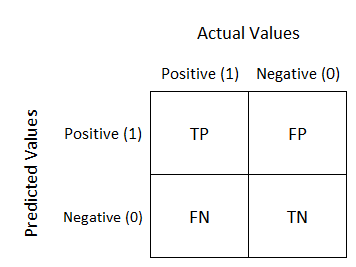

In [ ]:
# Gerando nossa matriz de confusão

mat_conf = confusion_matrix(y_teste, y_pred)

mat_conf

Um pouco feia e difícil de entender, vamos utilizar o seaborn para visualizar a confusão do modelo:

In [ ]:
# Defina os rótulos das classes
class_names = ['Adimplente', 'Inadimplente']

# Crie um gráfico de matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(mat_conf, # Nossa matriz gerada pelo sklearn
            annot=True,
            fmt='d', # Dígitos completos
            cmap='Blues', # Cor da matriz
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

Dos 69 inadimplentes (55 + 14) no banco de teste, apenas 14 foram corretamente classificados desta forma. Vemos que o modelo performa muito mal nesta classe. Além disso, podemos observar agora que há um grande desbalanceamento das classes, o que com certeza afeta nossos resultados. Podemos confirmar nossas suspeitas olhando para o *classification report* (Relatório de Classificação).

**Interpretação da Matriz de Confusão**:

A matriz de confusão ajuda a entender como um modelo está se comportando em diferentes cenários:

* Verdadeiros Positivos (TP): Representam os acertos do modelo, ou seja, os casos em que ele previu corretamente a classe positiva.

* Falsos Negativos (FN): Representam os erros do tipo I, indicando casos em que o modelo deveria ter previsto a classe positiva, mas previu negativa.

* Falsos Positivos (FP): Representam os erros do tipo II, indicando casos em que o modelo previu a classe positiva, mas deveria ter previsto negativa.

* Verdadeiros Negativos (TN): Representam os acertos do modelo na previsão da classe negativa.












**Métricas Derivadas da Matriz de Confusão**:

Com base nos elementos da matriz de confusão, você pode calcular várias métricas de avaliação de modelos de classificação, incluindo:

* **Precisão (Precision)**: TP / (TP + FP). Mede a proporção de previsões positivas corretas em relação ao total de previsões positivas feitas pelo modelo.

* **Revocação (Recall ou Sensibilidade)**: TP / (TP + FN). Mede a proporção de previsões positivas corretas em relação ao total de casos verdadeiros positivos.

* **Especificidade (Specificity)**: TN / (TN + FP). Mede a proporção de previsões negativas corretas em relação ao total de casos verdadeiros negativos.

* F-Score (ou F1-Score): 2 * (Precisão * Revocação) / (Precisão + Revocação). Uma métrica que combina precisão e revocação, sendo útil quando você deseja encontrar um equilíbrio entre as duas métricas.

* Taxa de Falsos Positivos (False Positive Rate - FPR): FP / (FP + TN). Mede a proporção de previsões incorretas de classe positiva em relação ao total de casos verdadeiros negativos.

A matriz de confusão e essas métricas associadas são cruciais para avaliar o desempenho de um modelo de classificação, especialmente em situações em que os erros têm diferentes consequências ou custos. Elas ajudam a entender como o modelo está tomando decisões e podem orientar ajustes para melhorar a precisão e revocação, dependendo dos objetivos específicos do projeto.

c) Classification Report

In [ ]:
rel_class = classification_report(y_teste, y_pred)

print(f"Relatório de Classificação:\n{rel_class}")

Aqui podemos ver mais claramente o problema. Apesar de ter ótimas métricas de precision e recall para a classe majoritária, adimplentes, (Leia mais sobre estas métricas [aqui](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#precision-recall)), o modelo peca muito na classificação de quem é inadimplente de fato, com apenas 47% de precisão (menos da metade do máximo de 100%) e um recall de 20% (que vai de 0 a 100). Isso deve servir como um alerta para não se confiar apenas em uma métrica, como a acurácia. Dependendo da qualidade do banco de dados, diversos problemas podem surgir, e podem escapar de algumas métricas.

## Exercícios

1 - Agora é sua vez, vamos pegar um outro banco de dados. Na pasta do laboratório, há um .csv chamado "Healthcare-Diabetes.csv", importe ele.

No seguinte kaggle ([link](https://www.kaggle.com/datasets/nanditapore/healthcare-diabetes/)) você encontra mais informações sobre o banco.

2 - Calcule a proporção de cada classe do target ('Outcome')

a) Discuta o balanceamento de classes deste banco de dados

Resposta:

3 - Faça uma matriz de correlação das variáveis independentes. Há alguma variável que pareça ser muito correlacionada com outra (muito próximo de 1)?

4 - Rode um modelo de regressão logística do **Statmodels** e imprima o summary. Utilize todas as variáveis do banco.

5 - De acordo com os resultados do exercício 4, quais variáveis tem efeito positivo nas chances de se ter diabetes?

RESPOSTA:

6 - E quais tem efeito negativo?

Resposta:

7 - Por fim, quais não são estatisticamente significantes?

Resposta:

8 - Separe as colunas em um vetor X de features e o target (Outcome). Também separe o banco entre treino e teste (com 20% para teste).

9 - Agora, treine um modelo de regressão logística utilizando o sklearn

10 - Faça a predição dos valores do banco de teste e imprima o array de predições.

11 - Apresente a acurácia do modelo

a) Discuta os resultados do modelo com base na acurácia:

RESPOSTA:

12 - Apresente a matriz de confusão do modelo

a) Compare os resultados desse modelo com o que rodamos para o banco *Default*. Qual a principal diferença entre esses dois bancos?

RESPOSTA:

13 - Por fim, apresente o relatório de classificação

a) O modelo foi bem? Discuta à luz dos resultados obtidos no banco default, do desbalanceamento das classes em ambos os bancos.

RESPOSTA: